## ResNet18

## Set 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


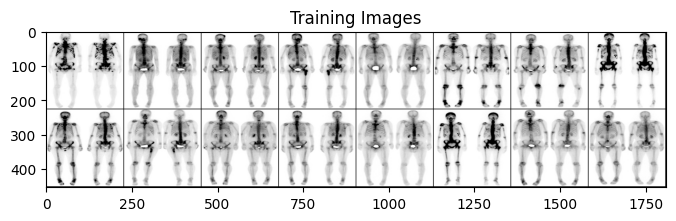

Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0])
Epoch [1/50], Train Loss: 0.49618399732755225, Test Loss: 0.5878175973892212, Test AUC: 0.7767
Epoch [2/50], Train Loss: 0.37299627483397435, Test Loss: 0.5767072528600693, Test AUC: 0.7894
Epoch [3/50], Train Loss: 0.3228092337009108, Test Loss: 0.642135563492775, Test AUC: 0.7897
Epoch [4/50], Train Loss: 0.280429829110943, Test Loss: 0.6515611499547959, Test AUC: 0.7955
Epoch [5/50], Train Loss: 0.25858367874639704, Test Loss: 0.6261659413576126, Test AUC: 0.7981
Epoch [6/50], Train Loss: 0.2297412376688088, Test Loss: 0.7587884992361069, Test AUC: 0.8084
Epoch [7/50], Train Loss: 0.22016388187365768, Test Loss: 0.6932123720645904, Test AUC: 0.8044
Epoch [8/50], Train Loss: 0.20118853365731182, Test Loss: 0.6856987819075584, Test AUC: 0.8195
Epoch [9/50], Train Loss: 0.1757634969844112, Test Loss: 0.7418571978807449, Test AUC: 0.8050
Epoch [10/50], Train Loss: 0.16709856290225555, Test Loss: 0.8269723296165467, Test AU

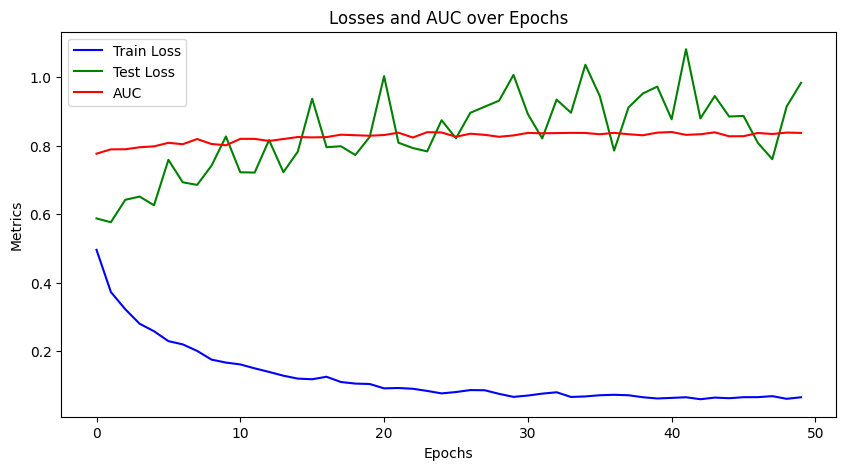

Accuracy: 0.71875
Sensitivity: 0.5
Specificity: 0.9375
PPV: 0.8888888888888888
NPV: 0.6521739130434783
AUC: 0.83734375
Precision: 0.8888888888888888
Recall: 0.5
F1-score: 0.64
Loss: 0.9835446579381824


In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet18_Weights
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
num_classes = 2
batch_size = 16
learning_rate = 0.0001

# Transformations applied to the image data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Datasets and Data Loaders
train_dataset = torchvision.datasets.ImageFolder(root='D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model setup: ResNet with custom classifier
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

# Retrieve number of input features to the fully connected layer
fc_inputs = model.fc.in_features

# Modified final layers with BatchNorm and Dropout
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 512),   # Added an additional fully connected layer for demonstration
    nn.BatchNorm1d(512),         # Batch Normalization
    nn.ReLU(),                   # Activation function
    nn.Dropout(0.5),             # Dropout
    nn.Linear(512, num_classes)  # Final layer
)

# Move model to GPU
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    losses = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            losses.append(criterion(outputs, labels).item())
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_probs.extend(probs.tolist())
    
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        'Accuracy': accuracy,
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp),
        'PPV': tp / (tp + fp),
        'NPV': tn / (tn + fn),
        'AUC': roc_auc_score(all_labels, all_probs),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1-score': f1_score(all_labels, all_preds),
        'Loss': np.mean(losses)
    }
    return metrics

# Training loop with added training data inspection and AUC recording
train_loss_over_epochs = []
test_loss_over_epochs = []
test_auc_over_epochs = []  # List to store the AUC for each epoch

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for i, (images, labels) in enumerate(train_loader):
        # Visualize some training data (only in the first epoch and first batch)
        if epoch == 0 and i == 0:
            plt.figure(figsize=(8, 8))
            out = torchvision.utils.make_grid(images)
            plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))
            plt.title("Training Images")
            plt.show()
            print("Labels:", labels)

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

    # Evaluate model to get metrics including AUC
    metrics = evaluate_model(model, test_loader)
    epoch_auc = metrics['AUC']
    test_auc_over_epochs.append(epoch_auc)  # Store AUC for plotting

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(val_losses)}, Test AUC: {epoch_auc:.4f}")

    if (epoch+1) % 10 == 0:
        for key, value in metrics.items():
            print(f"{key}: {value}")

    train_loss_over_epochs.append(np.mean(train_losses))
    test_loss_over_epochs.append(np.mean(val_losses))

    scheduler.step()

# Plotting for this fold
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

plt.plot(train_loss_over_epochs, label='Train Loss', color='blue')
plt.plot(test_loss_over_epochs, label='Test Loss', color='green')
plt.plot(test_auc_over_epochs, label='AUC', color='red')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Losses and AUC over Epochs')
plt.legend()

plt.show()

# Final evaluation and model saving
final_metrics = evaluate_model(model, test_loader)
for key, value in final_metrics.items():
    print(f"{key}: {value}")

torch.save(model.state_dict(), "my_model_resnet18_set1_e50.pth")

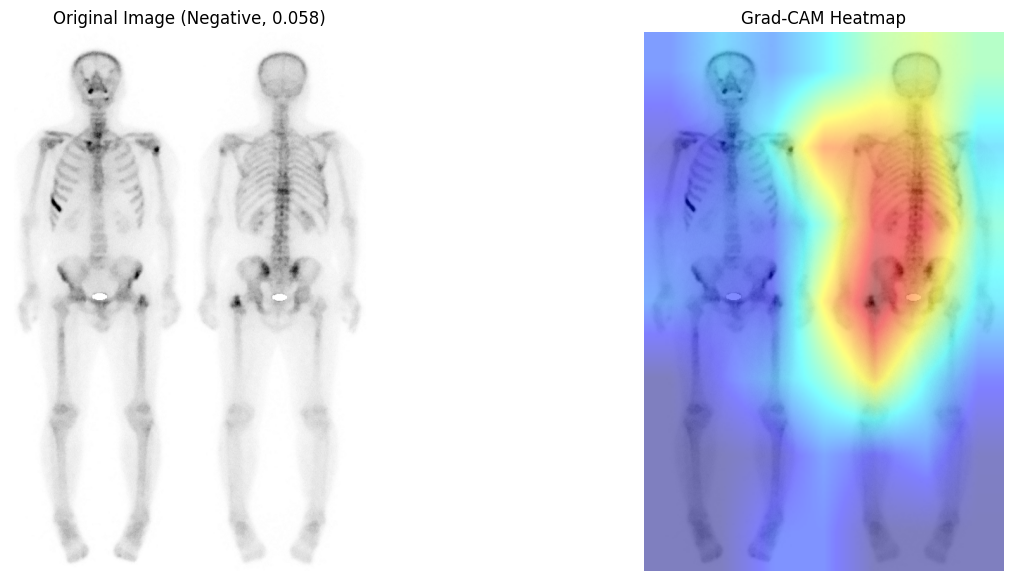

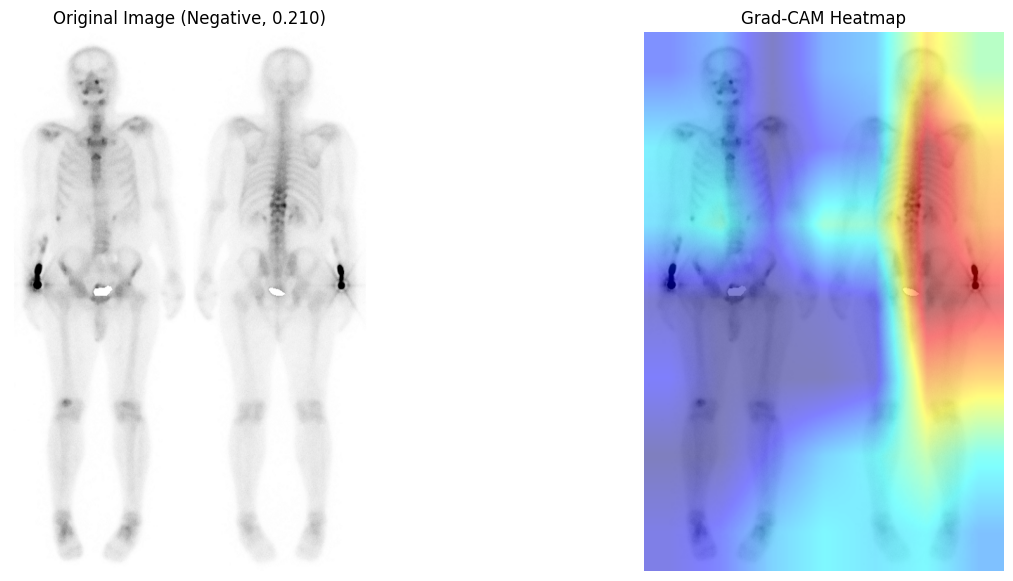

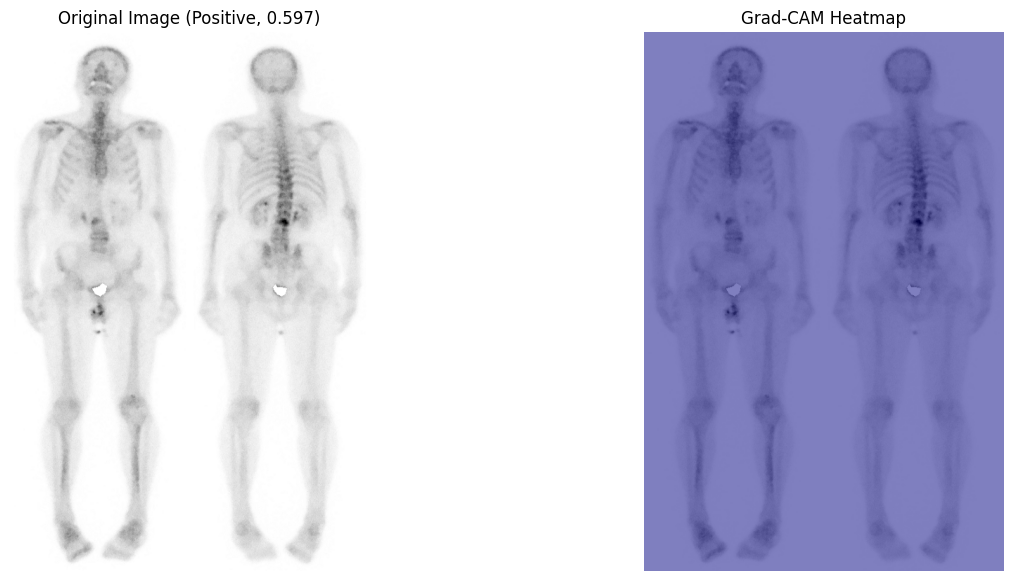

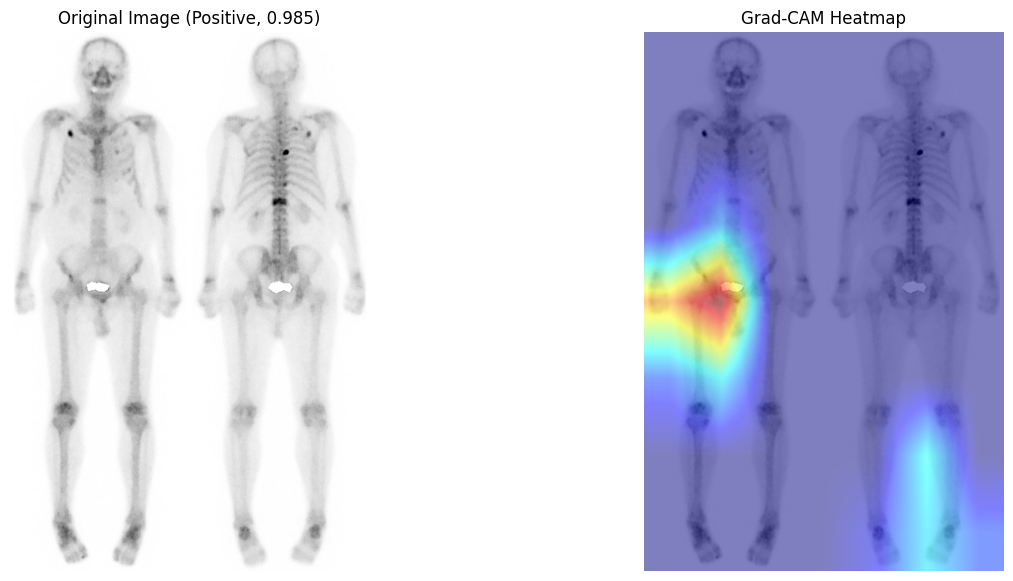

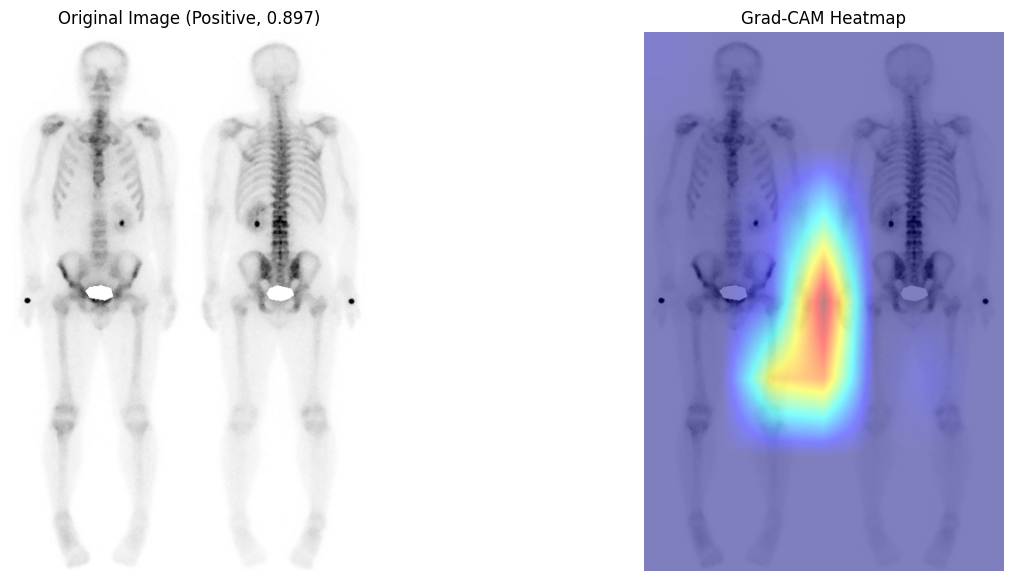

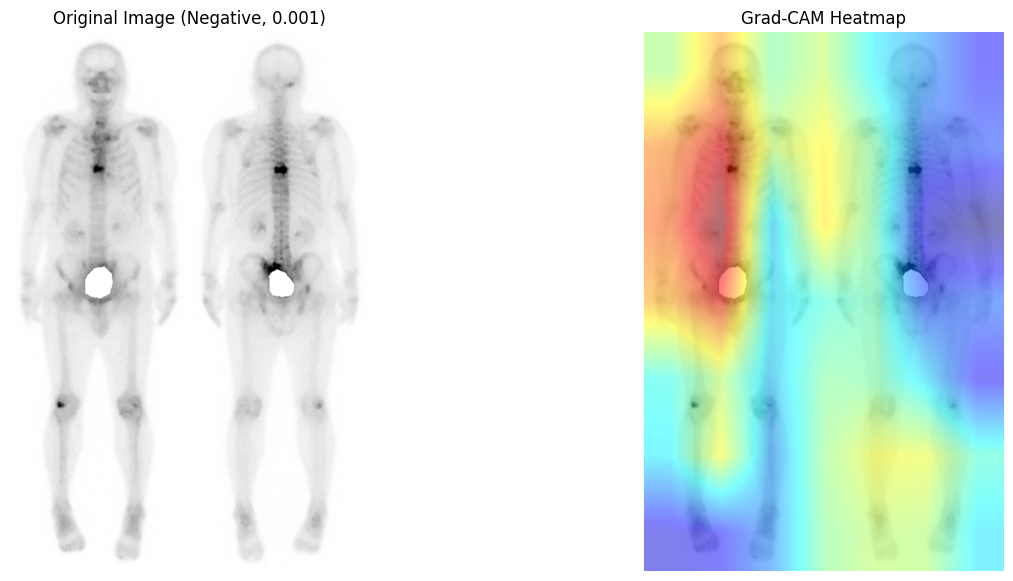

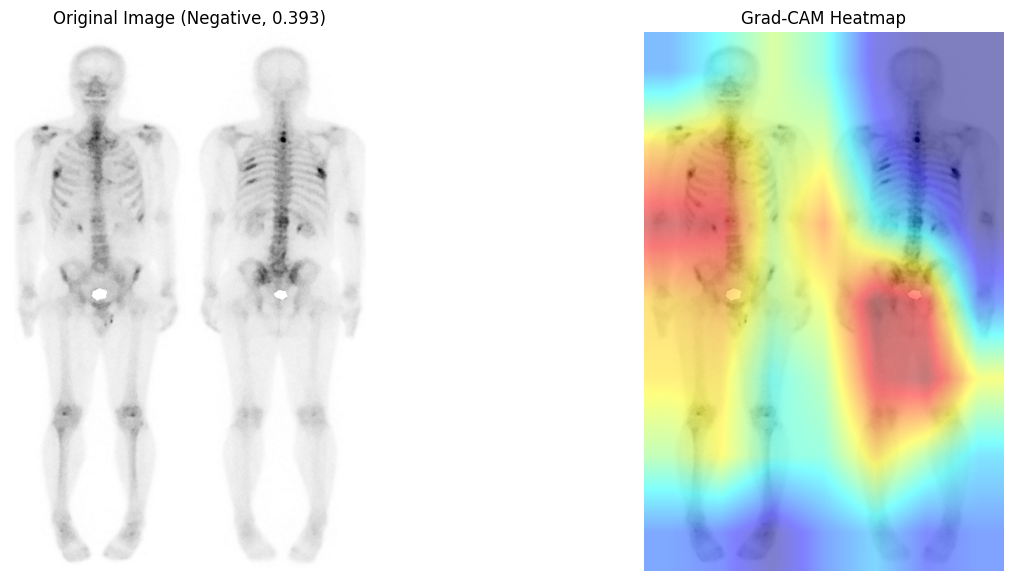

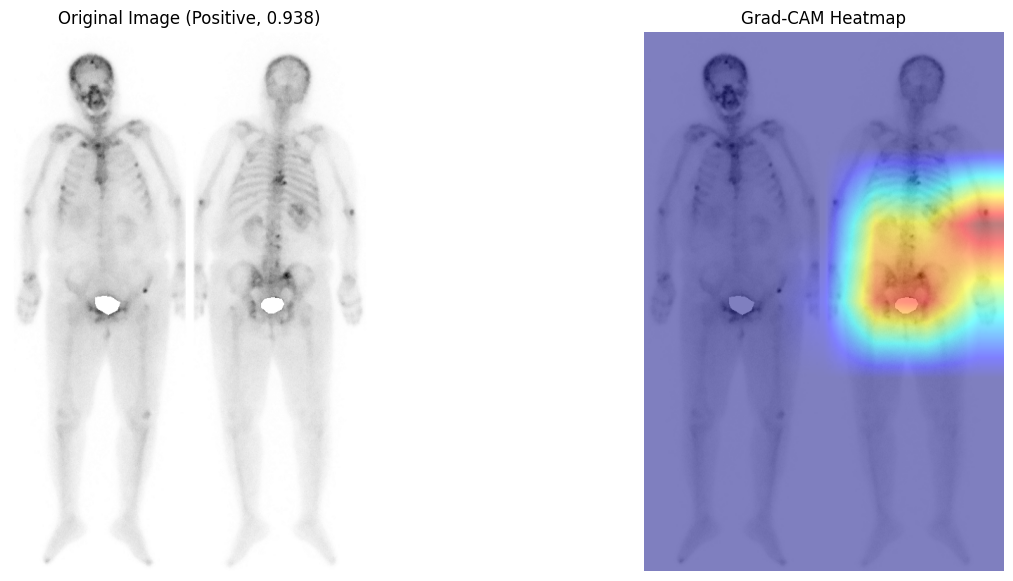

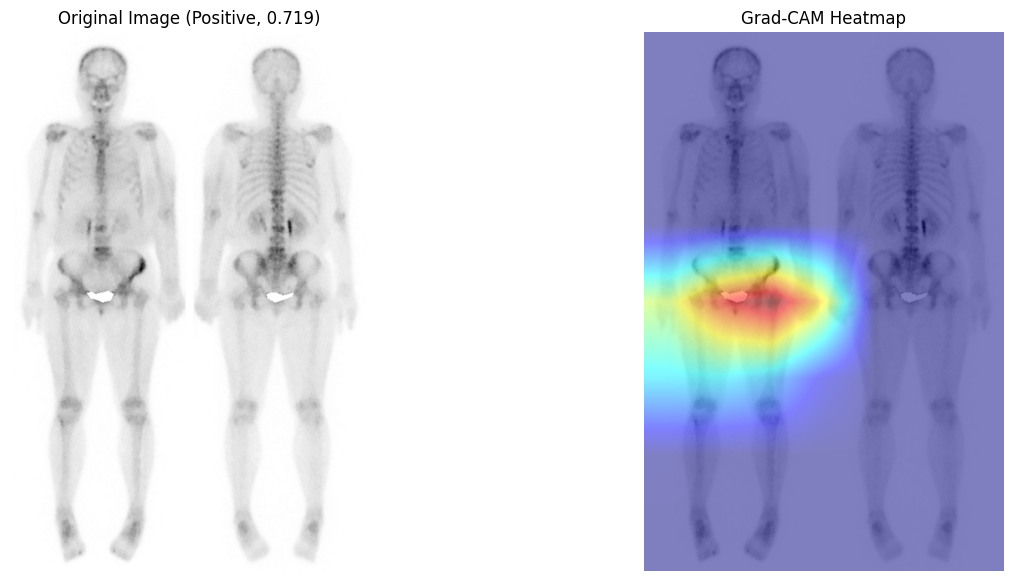

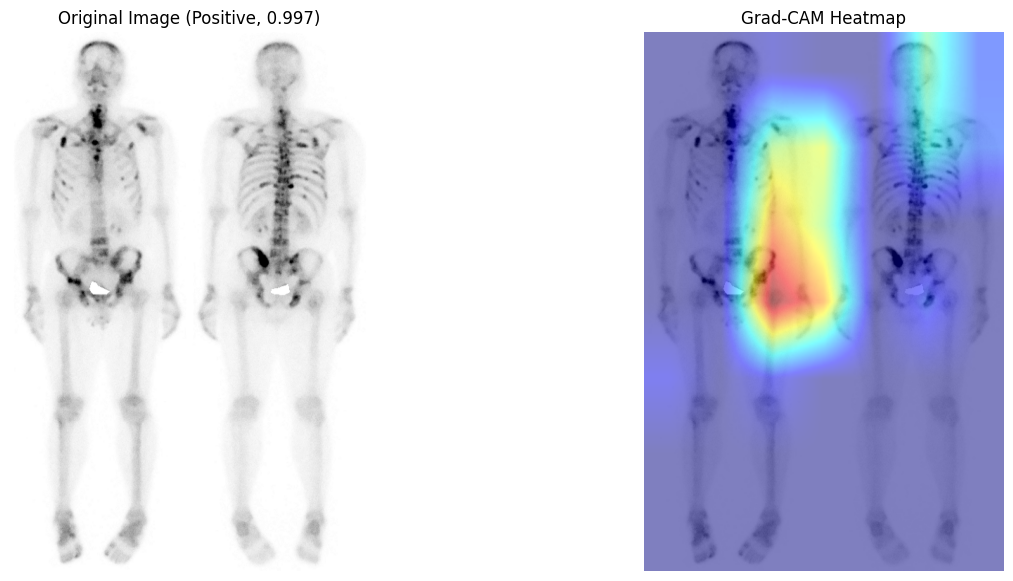

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models, transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet18_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Load the model
def load_trained_model(model_path):
    model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    fc_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(fc_inputs, 512),   # Added an additional fully connected layer for demonstration
        nn.BatchNorm1d(512),         # Batch Normalization
        nn.ReLU(),                   # Activation function
        nn.Dropout(0.5),             # Dropout
        nn.Linear(512, num_classes)  # Final layer
    )
    model.load_state_dict(torch.load("my_model_resnet18_set1_e50.pth"))
    model.to(device)
    model.eval()
    return model

# Assuming load_trained_model is defined elsewhere and it's properly loading a pre-trained model

def apply_grad_cam_and_classify(image_path, model, target_layer, transform, output_folder):
    img = Image.open(image_path).convert("RGB")
    original_size = img.size  # Store original size of the image

    img_transformed = transform(img).unsqueeze(0).to(device)  # Transform image for model input

    # Prediction and softmax probabilities
    with torch.no_grad():
        output = model(img_transformed)
        # probabilities = torch.softmax(output, dim=1)
        # predicted_class = probabilities.argmax(dim=1).item()
        # prob = probabilities[0, predicted_class].item()
        prob = torch.softmax(output, dim=1)[0][1].item()
        predicted_class = output.argmax(dim=1).item()

    # Create an instance of GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(predicted_class)]  # Targeting the predicted class
    grayscale_cam = cam(input_tensor=img_transformed, targets=targets)[0]

    # Resize heatmap to original image size
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, original_size, interpolation=cv2.INTER_LINEAR)

    # Overlay heatmap on original image
    img_np = np.array(img)
    superimposed_img = heatmap * 0.5 + img_np * 0.5

    # Determine class label
    label = "Positive" if predicted_class == 1 else "Negative"
    if label == "Positive":
        global num_positives
        num_positives += 1  # Update global count of positives

    # Saving the heatmap images
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    filename = os.path.splitext(os.path.basename(image_path))[0]
    plt.imsave(os.path.join(output_folder, f"{filename}_{label}.png"), superimposed_img.astype('uint8'))

    # Show the original and heatmap images
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image ({label}, {prob:.3f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# Global variable to count positives
num_positives = 0

# Setup and execution
test_images_dir = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/test/positive'
output_folder = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/heatmap_resnet18_positive_e50'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
model_path = "my_model_resnet18_set1_e50.pth"
model = load_trained_model(model_path)
target_layer = model.layer4[-1]

# Limit the processing to the first 10 images
image_paths = os.listdir(test_images_dir)[:10]
for image_path in image_paths:
    full_image_path = os.path.join(test_images_dir, image_path)
    apply_grad_cam_and_classify(full_image_path, model, target_layer, transform, output_folder)

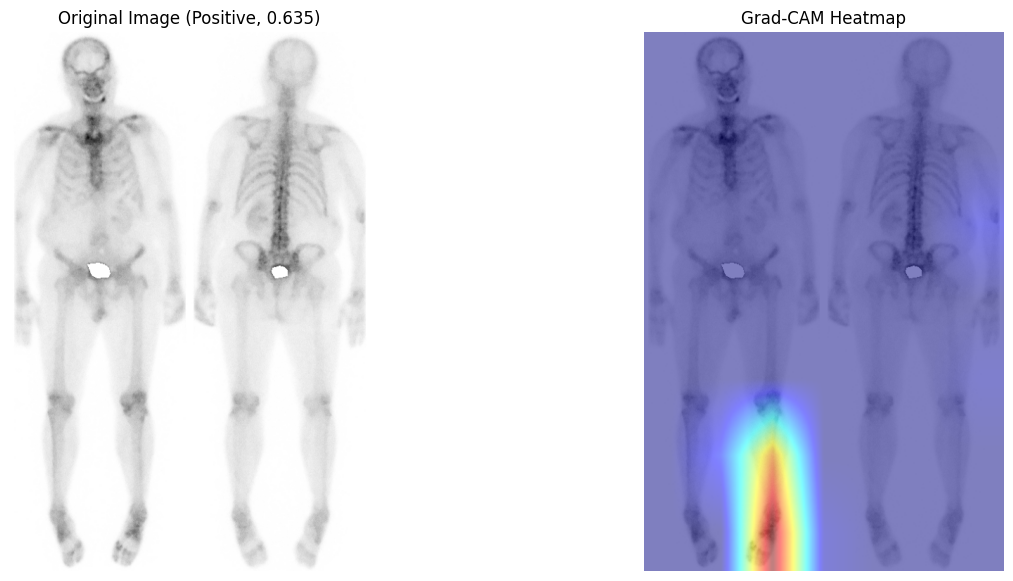

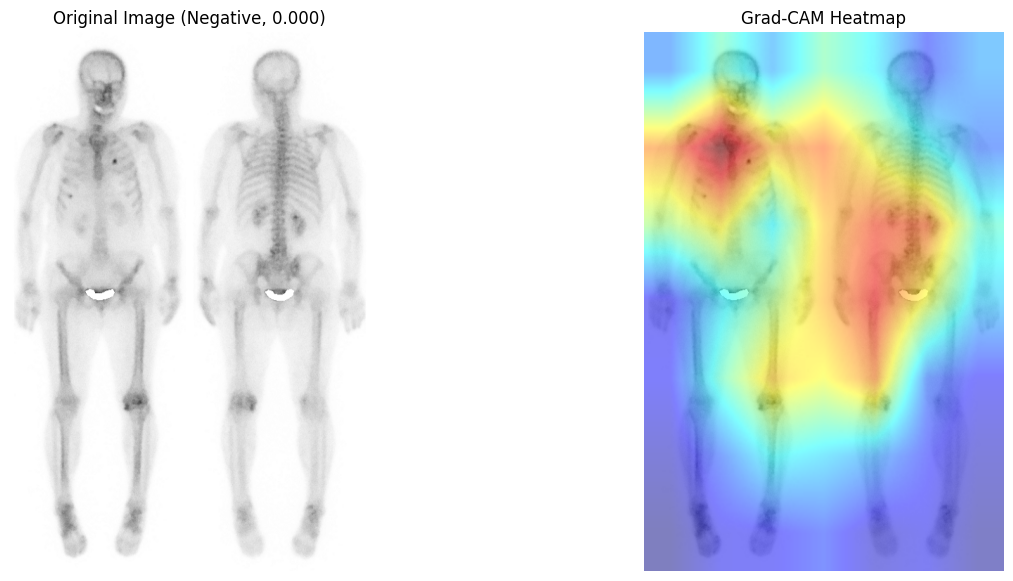

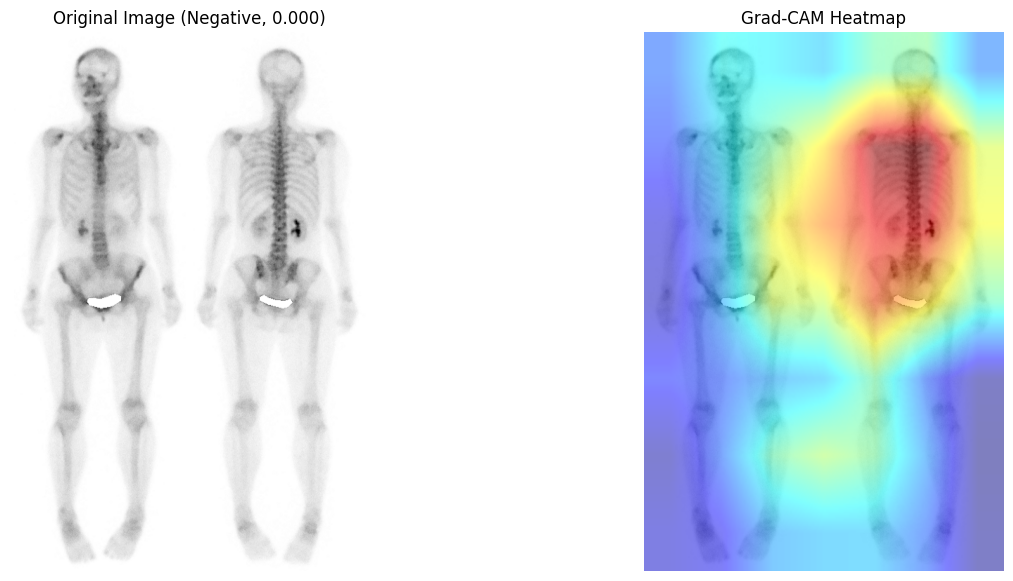

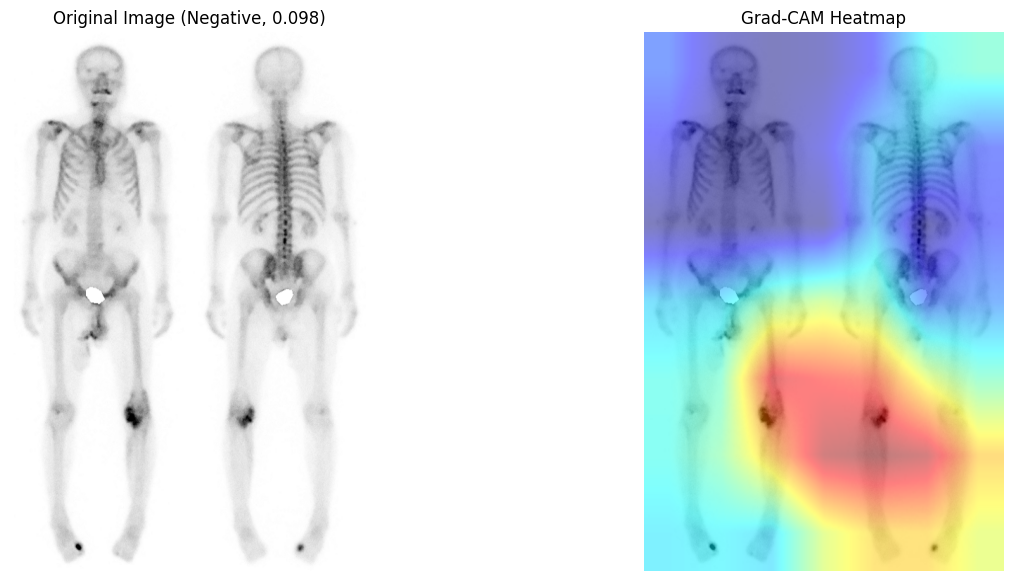

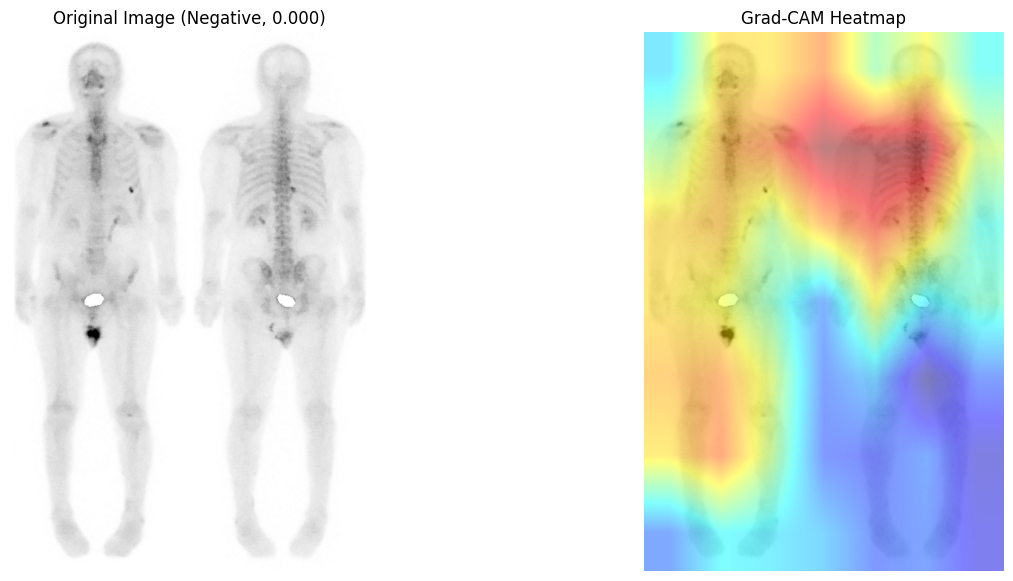

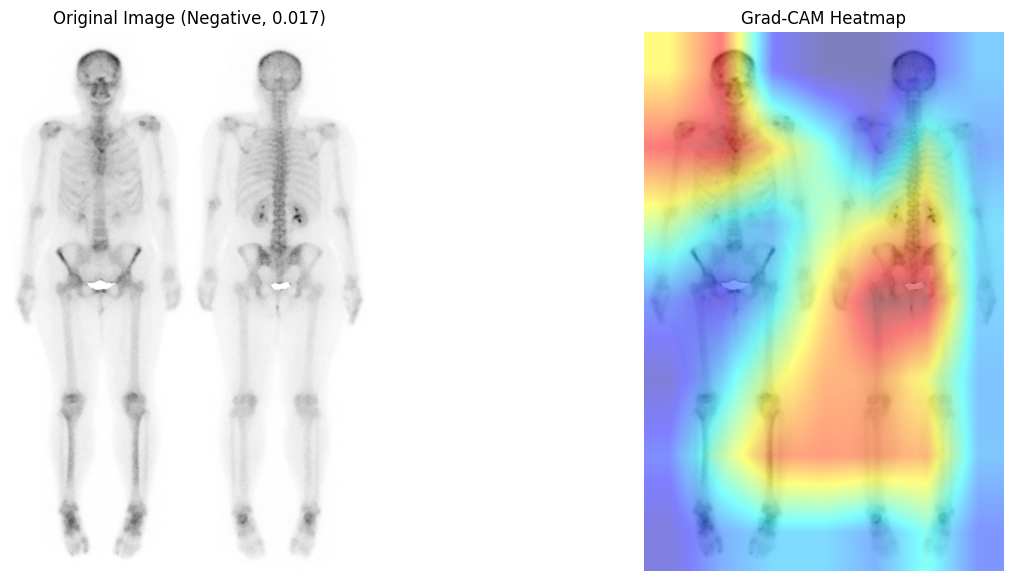

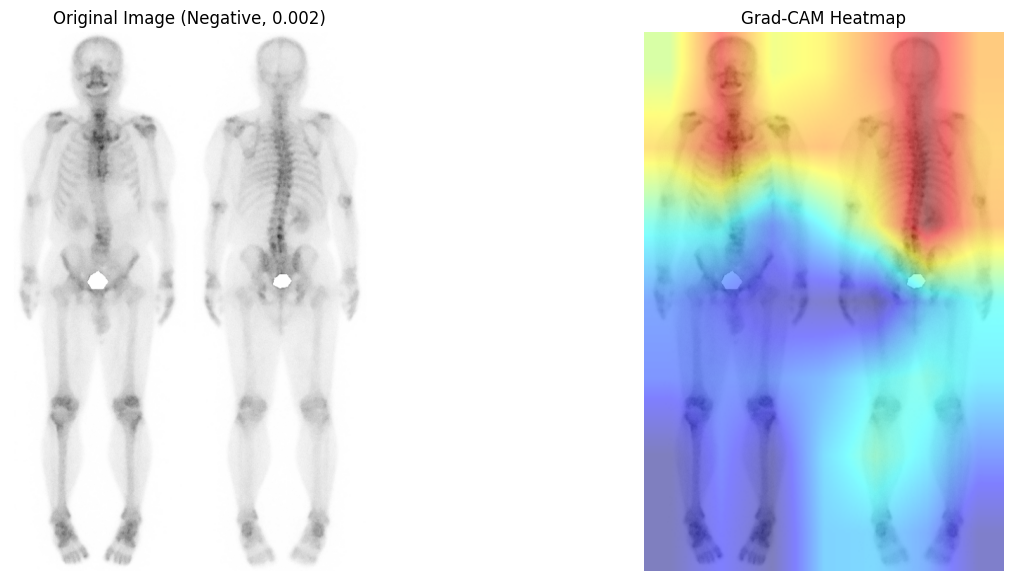

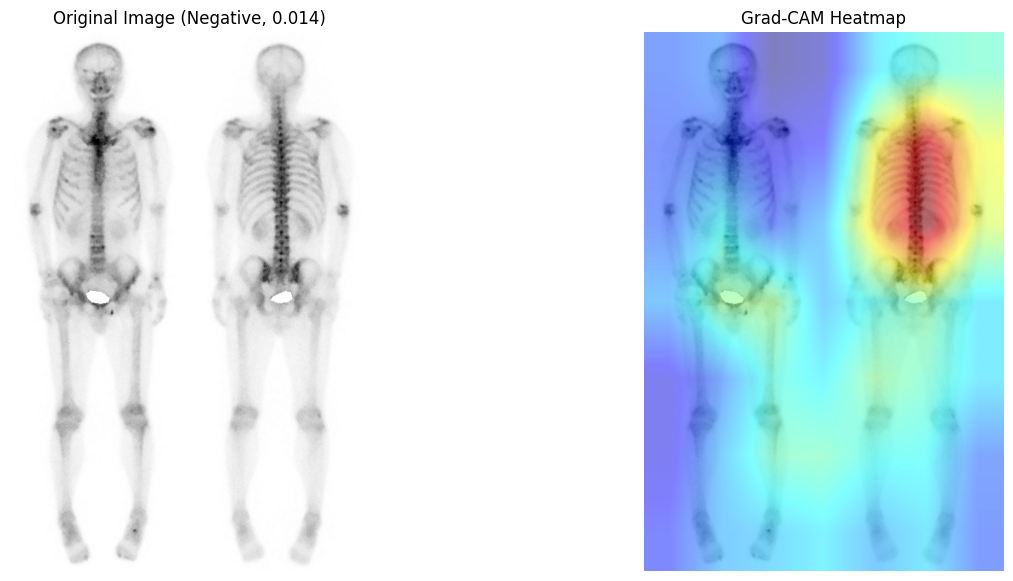

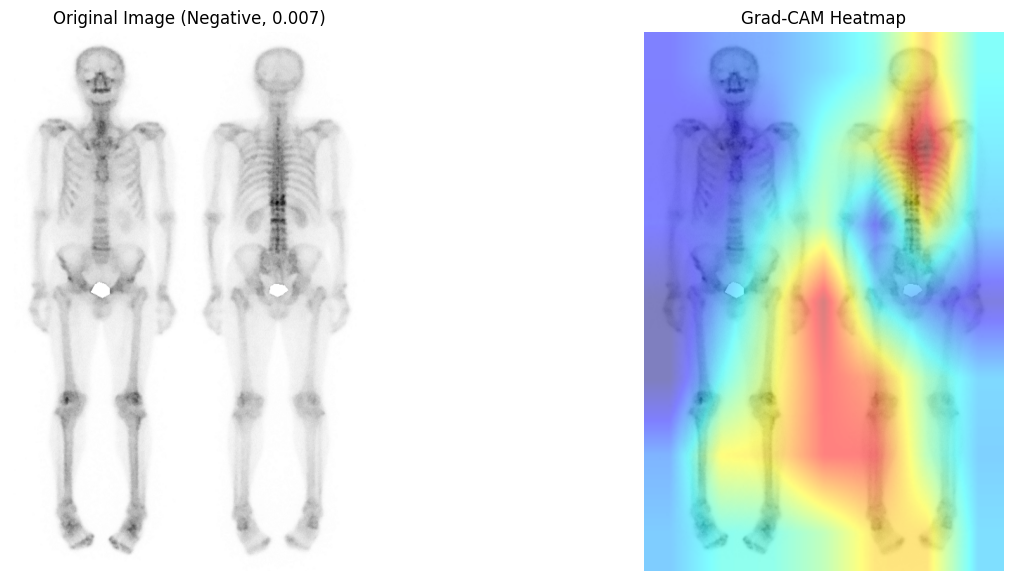

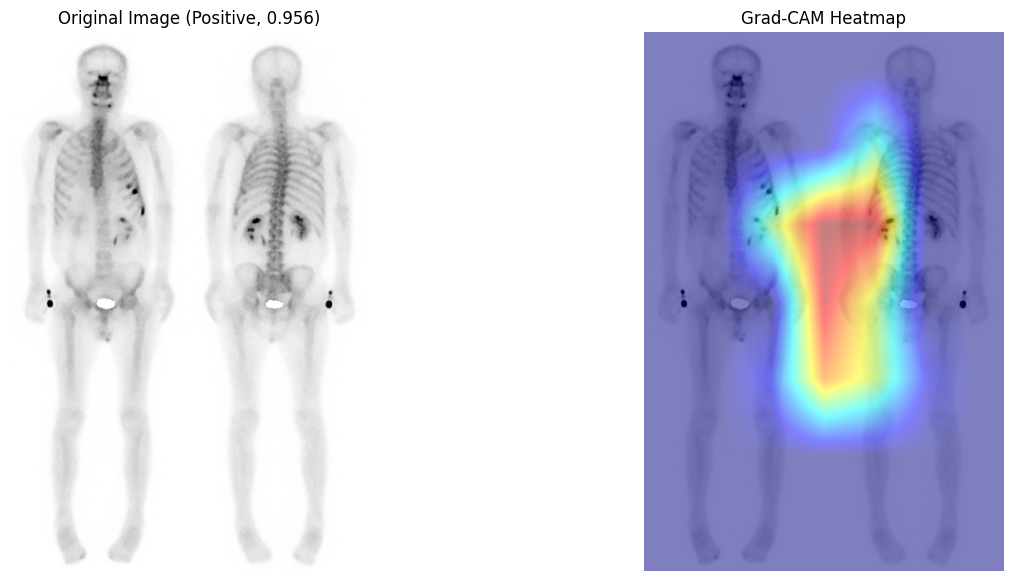

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models, transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet18_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Load the model
def load_trained_model(model_path):
    model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    fc_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(fc_inputs, 512),   # Added an additional fully connected layer for demonstration
        nn.BatchNorm1d(512),         # Batch Normalization
        nn.ReLU(),                   # Activation function
        nn.Dropout(0.5),             # Dropout
        nn.Linear(512, num_classes)  # Final layer
    )
    model.load_state_dict(torch.load("my_model_resnet18_set1_e50.pth"))
    model.to(device)
    model.eval()
    return model

# Assuming load_trained_model is defined elsewhere and it's properly loading a pre-trained model

def apply_grad_cam_and_classify(image_path, model, target_layer, transform, output_folder):
    img = Image.open(image_path).convert("RGB")
    original_size = img.size  # Store original size of the image

    img_transformed = transform(img).unsqueeze(0).to(device)  # Transform image for model input

    # Prediction and softmax probabilities
    with torch.no_grad():
        output = model(img_transformed)
        prob = torch.softmax(output, dim=1)[0][1].item()
        predicted_class = output.argmax(dim=1).item()

    # Create an instance of GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(predicted_class)]  # Targeting the predicted class
    grayscale_cam = cam(input_tensor=img_transformed, targets=targets)[0]

    # Resize heatmap to original image size
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, original_size, interpolation=cv2.INTER_LINEAR)

    # Overlay heatmap on original image
    img_np = np.array(img)
    superimposed_img = heatmap * 0.5 + img_np * 0.5

    # Determine class label
    label = "Positive" if predicted_class == 1 else "Negative"
    if label == "Positive":
        global num_positives
        num_positives += 1  # Update global count of positives

    # Saving the heatmap images
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    filename = os.path.splitext(os.path.basename(image_path))[0]
    plt.imsave(os.path.join(output_folder, f"{filename}_{label}.png"), superimposed_img.astype('uint8'))

    # Show the original and heatmap images
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image ({label}, {prob:.3f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# Global variable to count positives
num_positives = 0

# Setup and execution
test_images_dir = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/test/negative'
output_folder = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/heatmap_resnet18_negative_e50'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
model_path = "my_model_resnet18_set1_e50.pth"
model = load_trained_model(model_path)
target_layer = model.layer4[-1]

# Limit the processing to the first 10 images
image_paths = os.listdir(test_images_dir)[:10]
for image_path in image_paths:
    full_image_path = os.path.join(test_images_dir, image_path)
    apply_grad_cam_and_classify(full_image_path, model, target_layer, transform, output_folder)